**Creating Spatial Adjacency Matrix for each Suburb**

In [1]:
import pandas as pd
import geopandas as gpd

In [2]:
suburbs_gdf = gpd.read_file("../data/geo/shpfile/LOCALITY_POLYGON.shp")
list(suburbs_gdf["LOCALITY"].apply(lambda x: x.lower()))

['mollongghip',
 'north blackwood',
 'basalt',
 'llanelly',
 'murrabit west',
 'springfield (sea lake)',
 'waitchie',
 'straten',
 'gowanford',
 'kunat',
 'murrabit',
 'lake charm',
 'myall (kerang)',
 'pomonal',
 'kenley',
 'wandown',
 'towan',
 'bonnie doon',
 'terip terip',
 'emerald',
 'healesville',
 'thalloo',
 'princetown',
 'murrawee',
 'natya',
 'musk vale',
 'piangil',
 'beverford',
 'cocamba',
 'brucknell',
 'ada',
 'west wodonga',
 'lerderderg',
 'castle donnington',
 'korweinguboora',
 'robinvale',
 'rocklyn',
 'stanley',
 'buffalo river',
 'barrakee',
 'silvan',
 'kooloonong',
 'bullarto south',
 'bannerton',
 'french island',
 'wodonga',
 'sandringham',
 'monbulk',
 'broadlands',
 'metung',
 'narrung',
 'nyrraby',
 'glenroy',
 'kiewa',
 'grenville',
 'lake powell',
 'boundary bend',
 'laceby',
 'dooen',
 'pimpinio',
 'haven',
 'brighton',
 'lower norton',
 'horsham',
 'bungalally',
 'drung',
 'mckenzie creek',
 'glendonald',
 'kyvalley',
 'speed',
 'ultima',
 'tresco',
 

In [3]:
import geopandas as gpd
import numpy as np
from scipy.spatial import cKDTree
k = 5

# 1) Load suburbs and project to a metric CRS (meters)
if suburbs_gdf.crs is None or suburbs_gdf.crs.is_geographic:
    suburbs_gdf = suburbs_gdf.to_crs(3111)  # VIC metric; adjust if needed

# 2) Use centroids for nearest-neighbor search
centroids = suburbs_gdf.geometry.centroid
coords = np.column_stack([centroids.x, centroids.y])

# 3) KDTree: get the nearest other suburb (k=2; skip self at [:,1])
tree = cKDTree(coords)
dists, idxs = tree.query(coords, k=6)
nearest_idx = idxs[:, 1:]        # nearest other suburb index
nearest_dist_m = dists[:, 1:]    # distance in meters to nearest other suburb

# 4) Build a nearest-suburb mapping (use your name/id column)
name_col = "LOCALITY"  # change to your actual column
suburb_names = suburbs_gdf[name_col].tolist()
nearest_suburbs_by_name = {
    suburb_names[i]: list(
        zip(
            [suburb_names[j] for j in idx_row],    # neighbor names
            dist_row                               # matching distances
        )
    )
    for i, (idx_row, dist_row) in enumerate(zip(nearest_idx, nearest_dist_m))
}


# build column names
cols = [f"neighbor_{i+1}" for i in range(k)]

df_neighbors = (
    pd.DataFrame.from_dict(nearest_suburbs_by_name, orient="index")
    .iloc[:, :k]  # just in case some lists are longer
    .set_axis(cols, axis=1)
    .rename_axis("suburb")
    .reset_index()
)

df_neighbors.head()

,suburb,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5
0,MOLLONGGHIP,"(ROCKLYN, 3581.6783617685)","(BARKSTEAD, 5112.977817535254)","(DEAN, 5655.445908354546)","(CLARETOWN, 5791.793172209908)","(BULLAROOK, 5912.662413637704)"
1,NORTH BLACKWOOD,"(TRENTHAM EAST, 3494.2423289512035)","(TRENTHAM, 4989.125030380734)","(BARRYS REEF, 6228.475895469958)","(FERN HILL, 6806.431415276523)","(NEWBURY, 6881.401736031668)"
2,BASALT,"(HEPBURN, 2188.906580747685)","(ELEVATED PLAINS, 3060.2551791008445)","(SHEPHERDS FLAT, 3662.815869185455)","(HEPBURN SPRINGS, 3736.1011565495974)","(DRY DIGGINGS, 5152.962321160329)"
3,LLANELLY,"(TARNAGULLA, 5751.849152227316)","(ARNOLD, 6142.7344175566095)","(ARNOLD WEST, 7457.34599858082)","(MURPHYS CREEK, 7475.316184639746)","(NEWBRIDGE, 8146.6739503373665)"
4,MURRABIT WEST,"(GONN CROSSING, 4074.037812045385)","(BENJEROOP, 5425.375650080507)","(MURRABIT, 6310.258535531165)","(LAKE CHARM, 11055.729695651811)","(CAPELS CROSSING, 11402.874191071445)"


In [4]:
# Create a DataFrame to hold the adjacency matrix for each suburb
suburbs_list = list(suburbs_gdf["LOCALITY"].values)
connection_strength = 0.4
eps = 0.0001
matrix = pd.DataFrame(
        0.0, index=suburbs_list, columns=suburbs_list
    )

for suburb, neighbours in nearest_suburbs_by_name.items():
    for name, distance in neighbours:
        if suburb == name or distance == 0:
            continue  # skip self matches
        matrix.loc[suburb, name] = connection_strength / distance + eps
        matrix.loc[name, suburb] = connection_strength / distance + eps


matrix.head()

,MOLLONGGHIP,NORTH BLACKWOOD,BASALT,LLANELLY,MURRABIT WEST,SPRINGFIELD (SEA LAKE),WAITCHIE,STRATEN,GOWANFORD,KUNAT,...,PORT MELBOURNE,EXFORD,THOMASTOWN,WATSONIA,BACCHUS MARSH,CHRISTMAS HILLS,YARRA GLEN,HEIDELBERG WEST,RESERVOIR,PARWAN
MOLLONGGHIP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NORTH BLACKWOOD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BASALT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LLANELLY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MURRABIT WEST,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Spatial Connectivity Matrix (W):")
print("Values represent spatial influence weights (row-normalized)")
print(matrix.round(3))

# Visualize the spatial connectivity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, cmap='Blues', fmt='.3f', 
            square=True, cbar_kws={'label': 'Spatial Weight'})
plt.title('Spatial Connectivity Matrix Between Suburbs', fontsize=14)
plt.xlabel('Influenced Suburb')
plt.ylabel('Influencing Suburb')
plt.tight_layout()
plt.show()

Spatial Connectivity Matrix (W):
Values represent spatial influence weights (row-normalized)
                 MOLLONGGHIP  NORTH BLACKWOOD  BASALT  LLANELLY  \
MOLLONGGHIP              0.0              0.0     0.0       0.0   
NORTH BLACKWOOD          0.0              0.0     0.0       0.0   
BASALT                   0.0              0.0     0.0       0.0   
LLANELLY                 0.0              0.0     0.0       0.0   
MURRABIT WEST            0.0              0.0     0.0       0.0   
...                      ...              ...     ...       ...   
CHRISTMAS HILLS          0.0              0.0     0.0       0.0   
YARRA GLEN               0.0              0.0     0.0       0.0   
HEIDELBERG WEST          0.0              0.0     0.0       0.0   
RESERVOIR                0.0              0.0     0.0       0.0   
PARWAN                   0.0              0.0     0.0       0.0   

                 MURRABIT WEST  SPRINGFIELD (SEA LAKE)  WAITCHIE  STRATEN  \
MOLLONGGHIP              

KeyboardInterrupt: 

: 

: 

In [6]:
ts_suburbs_df = pd.read_csv("../data/curated/rent_growth/panel_data_updates.csv")
merged_dict_list = [{c : c.split("-")} for c in (set(ts_suburbs_df["suburb"]) - set((suburbs_gdf["LOCALITY"].apply(lambda x: x.lower()))))]

In [7]:
unmerged_suburbs = []
for combined_dict in merged_dict_list:
    for val_list in combined_dict.values():
        for vals in val_list:
            unmerged_suburbs.append(vals)

unmerged_suburbs

['glen waverley',
 'mulgrave',
 'ivanhoe',
 'ivanhoe east',
 'murrumbeena',
 'hughesdale',
 'heidelberg',
 'heidelberg west',
 'vermont',
 'forest hill',
 'burwood east',
 'flemington',
 'kensington',
 'doncaster east',
 'donvale',
 'mentone',
 'parkdale',
 'mordialloc',
 'thomastown',
 'lalor',
 'east st kilda',
 'prahran',
 'windsor',
 'aspendale',
 'chelsea',
 'carrum',
 'dandenong north',
 'endeavour hills',
 'keilor east',
 'avondale heights',
 'yarraville',
 'seddon',
 'flora hill',
 'bendigo east',
 'werribee',
 'hoppers crossing',
 'moonee ponds',
 'ascot vale',
 'narre warren',
 'hampton park',
 'oak park',
 'glenroy',
 'fawkner',
 'wendouree',
 'alfredton',
 'fitzroy north',
 'clifton hill',
 'broadmeadows',
 'roxburgh park',
 'east brunswick',
 'north melbourne',
 'west melbourne',
 'mount clear',
 'buninyong',
 'pascoe vale',
 'coburg north',
 'burwood',
 'ashburton',
 'golden square',
 'kangaroo flat',
 'moe',
 'newborough',
 'albert park',
 'middle park',
 'west st kilda'

In [8]:
set(unmerged_suburbs) - set((suburbs_gdf["LOCALITY"].apply(lambda x: x.lower())))

{'bendigo east',
 'east brunswick',
 'east hawthorn',
 'east st kilda',
 'mt eliza',
 'mt martha',
 'newcombe',
 'newtown',
 'wanagaratta',
 'west brunswick',
 'west st kilda'}

In [13]:
W = matrix
W = W.div(W.sum(axis=1), axis=0).fillna(0)


In [11]:
mapping = {k:v for d in merged_dict_list for k, v in d.items()}

list(mapping.keys())

['glen waverley-mulgrave',
 'ivanhoe-ivanhoe east',
 'murrumbeena-hughesdale',
 'heidelberg-heidelberg west',
 'vermont-forest hill-burwood east',
 'flemington-kensington',
 'doncaster east-donvale',
 'mentone-parkdale-mordialloc',
 'thomastown-lalor',
 'east st kilda',
 'prahran-windsor',
 'aspendale-chelsea-carrum',
 'dandenong north-endeavour hills',
 'keilor east-avondale heights',
 'yarraville-seddon',
 'flora hill-bendigo east',
 'werribee-hoppers crossing',
 'moonee ponds-ascot vale',
 'narre warren-hampton park',
 'oak park-glenroy-fawkner',
 'wendouree-alfredton',
 'fitzroy north-clifton hill',
 'broadmeadows-roxburgh park',
 'east brunswick',
 'north melbourne-west melbourne',
 'mount clear-buninyong',
 'pascoe vale-coburg north',
 'burwood-ashburton',
 'golden square-kangaroo flat',
 'moe-newborough',
 'albert park-middle park-west st kilda',
 'st albans-deer park',
 'sebastopol-delacombe',
 'ocean grove-barwon heads',
 'gladstone park-tullamarine',
 'newtown',
 'hastings-fl

In [12]:
mapping = {k:v for d in merged_dict_list for k, v in d.items()}

W_new = pd.DataFrame(0, index=list(mapping.keys()), columns=list(mapping.keys()))

for combo_i, parts_i in mapping.items():
    for combo_j, parts_j in mapping.items():
        try:
            submatrix = W.loc[parts_i, parts_j]
            if not submatrix.empty:
                W_new.loc[combo_i, combo_j] = submatrix.values.mean()
            else:
                W_new.loc[combo_i, combo_j] = 0
        except KeyError:
            # One or more suburbs missing in original W
            W_new.loc[combo_i, combo_j] = 0


In [15]:
W_new = W_new.div(W_new.sum(axis=1), axis=0).fillna(0)

In [ ]:
# Persist curated spatial connectivity matrix for downstream use
from pathlib import Path
output_dir = Path('../data/curated/spatial_weights')
output_dir.mkdir(parents=True, exist_ok=True)
output_path = output_dir / 'spatial_connectivity_matrix.csv'
W_new.to_csv(output_path, index=True)
print(f'Saved curated spatial weight matrix to {output_path}')


Spatial Connectivity Matrix (W):
Values represent spatial influence weights (row-normalized)
                                     glen waverley-mulgrave  \
glen waverley-mulgrave                                  0.0   
ivanhoe-ivanhoe east                                    0.0   
murrumbeena-hughesdale                                  0.0   
heidelberg-heidelberg west                              0.0   
vermont-forest hill-burwood east                        0.0   
...                                                     ...   
eltham-research-montmorency                             0.0   
canterbury-surrey hills-mont albert                     0.0   
mill park-epping                                        0.0   
camberwell-glen iris                                    0.0   
newport-spotswood                                       0.0   

                                     ivanhoe-ivanhoe east  \
glen waverley-mulgrave                                0.0   
ivanhoe-ivanhoe east        

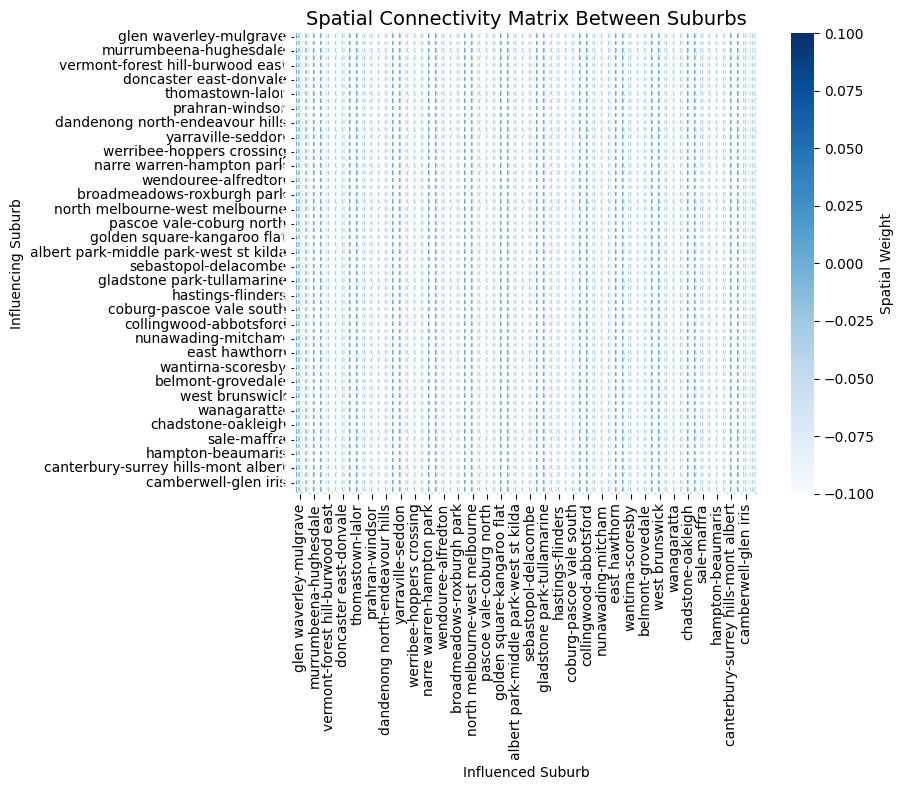

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Spatial Connectivity Matrix (W):")
print("Values represent spatial influence weights (row-normalized)")
print(W_new.round(3))

# Visualize the spatial connectivity W_new
plt.figure(figsize=(10, 8))
sns.heatmap(W_new, annot=True, cmap='Blues', fmt='.3f', 
            square=True, cbar_kws={'label': 'Spatial Weight'})
plt.title('Spatial Connectivity Matrix Between Suburbs', fontsize=14)
plt.xlabel('Influenced Suburb')
plt.ylabel('Influencing Suburb')
plt.tight_layout()
plt.show()